# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [1]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [45]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # input channel = ?, output channels = ?, kernel size = ?
    # input image size = (?, ?), image output size = (?, ?)
    self.conv_1 = torch.nn.Conv2d(1, 6, kernel_size=(5, 5), padding=2)

    # input channel = ?, output channels = ?, kernel size = ?
    # input image size = (?, ?), output image size = (?, ?)
    self.conv_2 = torch.nn.Conv2d(6, 16, kernel_size=(5, 5))

    # input dim = ? ( H x W x C), output dim = ?
    self.linear_1 = torch.nn.Linear(16*5*5, 120)

    # input dim = ?, output dim = ?
    self.linear_2 = torch.nn.Linear(120, 84)

    # input dim = ?, output dim = ?
    self.linear_3 = torch.nn.Linear(84, 10)
    
    self.dropout = torch.nn.Dropout(p=0.5)

  def forward(self, x):

    x = self.conv_1(x)
    x = torch.nn.functional.relu(x)
    # Max Pooling with kernel size = ?
    # output size = (?, ?)
    x = torch.nn.functional.max_pool2d(x, kernel_size=(2, 2), stride=2)

    x = self.conv_2(x)
    x = torch.nn.functional.relu(x)
    # Max Pooling with kernel size = ?
    # output size = (?, ?)
    x = torch.nn.functional.max_pool2d(x, kernel_size=(2, 2), stride=2)


    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)

    x = self.linear_1(x)
    x = torch.nn.functional.relu(x)
    x = self.dropout(x)

    x = self.linear_2(x)
    x = torch.nn.functional.relu(x)
    x = self.dropout(x)

    x = self.linear_3(x)

    return x

### Define cost function

In [16]:
def get_cost_function():
  cost_function = torch.nn.MSELoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [17]:
def get_optimizer(net, lr, wd, momentum):
  optimizer =  torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

### Train and test functions

In [49]:
def test(net, data_loader, cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      one_hot_targets = F.one_hot(targets, num_classes=10).float()
      loss = cost_function(outputs, one_hot_targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    one_hot_targets = F.one_hot(targets, num_classes=10).float()
    loss = cost_function(outputs, one_hot_targets)


    # Reset the optimizer

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [50]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True, n_workers=12)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False, n_workers=12)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False, n_workers=12)

  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [66]:
def main(batch_size=128,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50,
         early_stopping_patience=5):

    train_loader, val_loader, test_loader = get_data(batch_size)

    net = LeNet()
    net.to(device)

    optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

    cost_function = get_cost_function()

    print('Before training:')
    train_loss, train_accuracy = test(net, train_loader, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    test_loss, test_accuracy = test(net, test_loader, cost_function)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for e in range(epochs):
        train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
        val_loss, val_accuracy = test(net, val_loader, cost_function)
        
        print('Epoch: {:d}'.format(e + 1))
        print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
        print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
        print('-----------------------------------------------------')

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        # Early stopping
        if epochs_without_improvement >= early_stopping_patience:
            print(f'Stopping early after {e+1} epochs due to no improvement in validation loss for {early_stopping_patience} consecutive epochs.')
            break

    print('After training:')
    train_loss, train_accuracy = test(net, train_loader, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    test_loss, test_accuracy = test(net, test_loader, cost_function)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')
  
    # Save the model
    torch.save(net.state_dict(), 'LeNet_early_stopping.pth')

Lets train!

In [67]:
main()

Before training:
	 Training loss 0.00083, Training accuracy 8.64
	 Validation loss 0.00042, Validation accuracy 8.62
	 Test loss 0.00042, Test accuracy 8.24
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00069, Training accuracy 30.51
	 Validation loss 0.00033, Validation accuracy 49.92
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00056, Training accuracy 59.30
	 Validation loss 0.00023, Validation accuracy 73.49
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00037, Training accuracy 82.09
	 Validation loss 0.00015, Validation accuracy 87.64
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00025, Training accuracy 90.06
	 Validation loss 0.00011, Validation accuracy 91.56
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00019, Training accuracy 92.76
	 Validation loss 0.00009, Validation accuracy 93.35
------------------

In [62]:
# Load the LeNet model from the saved file
net = LeNet()
net.to(device='cuda:0')
net.load_state_dict(torch.load('LeNet.pth'))
net.eval()

train_loader, val_loader, test_loader = get_data(batch_size=128)

cost_function = get_cost_function()

test_loss, test_accuracy = test(net, test_loader, cost_function)
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))

	 Test loss 0.00002, Test accuracy 98.46


Using the proper metric from sklearn, check which character is most frequently confused with which: can you explain why ?



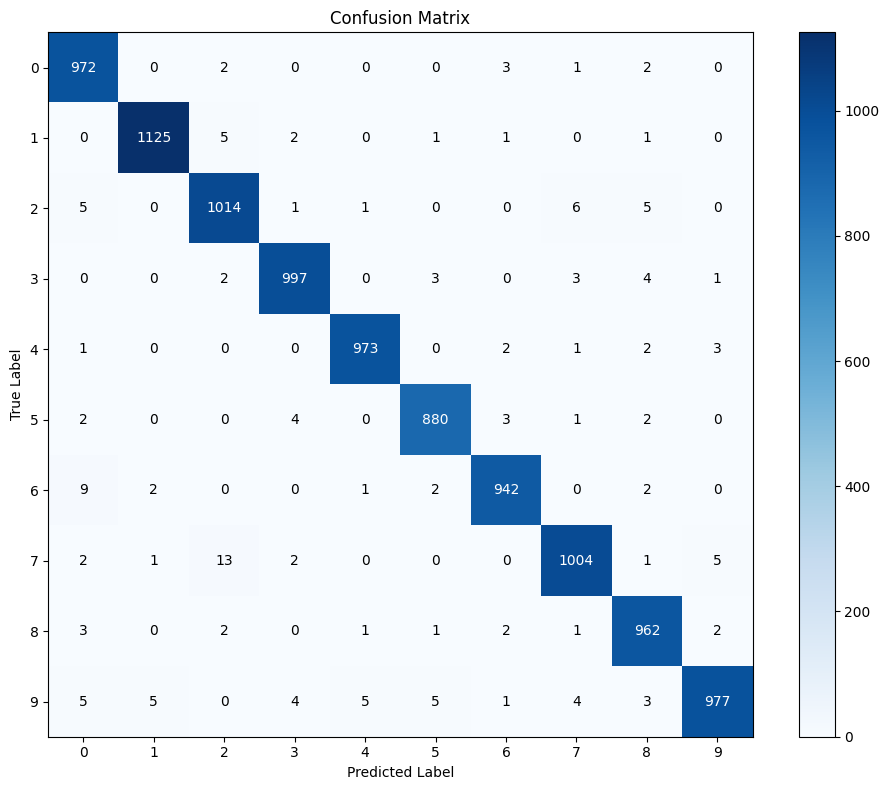

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Set the device
device = 'cuda:0'

# Set the network to evaluation mode
net.eval()

# Initialize the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test data loader
for inputs, targets in test_loader:
    # Move the inputs and targets to the device
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Get the predicted labels
    _, predicted = outputs.max(1)

    # Append the true labels and predicted labels
    true_labels.extend(targets.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add number to each cell
thresh = cm.max() / 2.  # Define a threshold to set text color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

The LeNet5 architecture can also be implemented using the sequential API ([see documentation ](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

In [ ]:
le_net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=(5, 5), padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    torch.nn.Conv2d(6, 16, kernel_size=(5, 5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(16*5*5, 120),
    torch.nn.ReLU(),
    torch.nn.Linear(120, 84),
    torch.nn.ReLU(),
    torch.nn.Linear(84, 10)
)

##Experiments


* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.



